# **Flower Classification Competition (40%)**
For this competition, we will use the Flower Recognition (https://cloudstor.aarnet.edu.au/plus/s/1n6XuPUCwJ0MkgN). This dataset contains 4317 images of flowers. The data collection is based on the data flicr, google images, yandex images. You can use this datastet to recognize plants from the photo.  

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

We provide a baseline by the following steps:

*   Loding and Analysing the Flowers dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 
*   Generate prediction for the random test image(s). 

The following trick/tweak(s) could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Your code should be modified from the provided baseline. A pdf report is required to explain the tricks you employed, and the imporvements they achieved.
Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark = acc_mark + efficiency mark + report mark + bonus mark
###Acc_mark 15:

We will rank all the submission results based on their test accuracy. The top 30% of the students will get full marks.

|Accuracy|Mark|
|---|---|
| Top 30% in the class|          15|
|30%-50%|         11|
|50%-80%  |        7|
| 80%-90%  |      3|
| 90%-100%  |      1|
|Not implemented| 0|

###Efficiency mark 5:

Efficiency is evaluated by the computational costs (flops: https://en.wikipedia.org/wiki/FLOPS). Please report the computational costs for your final model and attach the code/process about how you calculate it.

|Efficiency|Mark|
|---|---|
| Top 30% in the class|          5|
|30%-50%|         4|
|50%-80%  |        3|
| 80%-90%  |      2|
| 90%-100%  |      2|
|Not implemented| 0|

###Report mark 20:
1. Introduction and your understanding to the baseline model: 2 points

2. Employed more than three tricks with ablation studies to improve the accuracy: 6 points

Clearly explain the reference, motivation and design choice for each trick/tweak(s). Providing the experimental results in tables.
Example table:

|Trick1|Trick2|Trick3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

Observation and discussion based on the experiment results.

3. Expaination of the methods on reducing the computational cost and/or improve the trade-off between accuracy and efficiency: 4 points

4. Explaination of the code implementation：3 points

5. Visulization results: e.g. training and testing accuracy/loss for each model, case studies: 3 points

6. Open ended:  Limitations, conclusions, failure cases analysis...: 2 points

###Bouns mark:
1. Top three results: 2 points
2. Fancy designs: 2 points

In [16]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2022
### Student Name: Lujie Ma, Wenlong Dai
### Student ID: a1810558, a1777081
### Comptetion Name: Flowers Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [17]:
# Importing libraries. 

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [18]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path.
data_directory = '/Users/xavier/Desktop/CV/CV_project/CV-project/flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /Users/xavier/Desktop/CV/CV_project/CV-project/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [19]:
# Performing Image Transformations. 

train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [20]:
# Checking the flower class types.
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [21]:
# Train and Test data split. 
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [22]:
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10)

In [23]:
print(len(train_data))
print(len(test_data))

3453
864


In [24]:
# Preview of the datasets. 
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [2 1 0 1 1 4 2 3 0 0]
Class: rose dandelion daisy dandelion dandelion tulip rose sunflower daisy daisy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


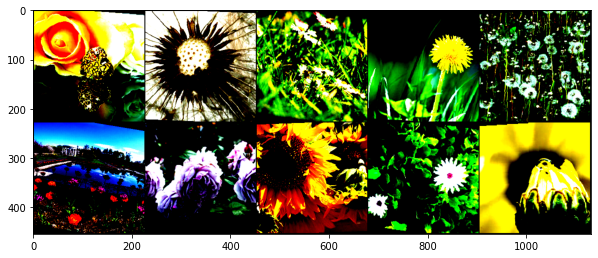

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [26]:
# Inverse Normalization. 
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

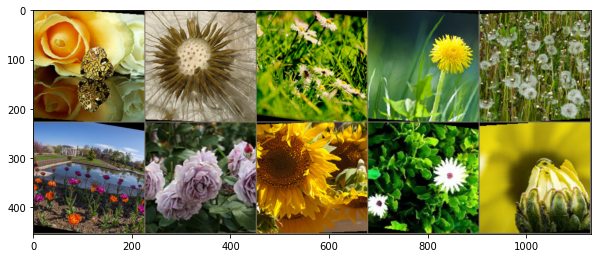

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [28]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120) 
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        
        return F.log_softmax(X, dim=1)

In [29]:
num_classes = 5
CNNmodel=ConvolutionalNetwork(num_classes)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=0.001)

In [30]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=5, bias=True)
)

In [31]:
# Counting of number of parameters in the model.
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
     100
       5
________
 5611857


In [32]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=5

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1                                            
        y_pred=CNNmodel(X_train)
        loss=criterion(y_pred,y_train)

        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=CNNmodel(X_test)
            loss=criterion(y_val,y_test)
            
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 0 loss: <built-in method item of Tensor object at 0x7f80bdf1ff48> batch: 200 accuracy:  39.700%
epoch: 1 loss: <built-in method item of Tensor object at 0x7f80bdf0b548> batch: 200 accuracy:  55.000%
epoch: 2 loss: <built-in method item of Tensor object at 0x7f80beaaf188> batch: 200 accuracy:  59.400%
epoch: 3 loss: <built-in method item of Tensor object at 0x7f80beaaf318> batch: 200 accuracy:  62.250%


KeyboardInterrupt: 

In [ ]:
# Plotting loss over time. 
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

In [ ]:
x=100
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
test_data[x][0].shape

In [ ]:
# Prediction for one of the samples. 
CNNmodel.eval()
with torch.no_grad():
    new_pred=CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

##FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 5
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)